In [ ]:
import pulp
import numpy as np
import pandas as pd
from sklearn import  *
import random
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


start_time = time.time()

# preprocess, make train and test
df = pd.read_excel('2clstrain1200.xlsx',header=None)


x = df.iloc[:,:2].values
y =  np.reshape(df.iloc[:,2:].values,(1,len(df.iloc[:,2:].values)))[0]



# x = df.iloc [:, :2].values
# y = np.reshape(df.iloc[ : , 2: ].values,(1,len(df.iloc[ : , 2: ]))) [0]


# x_train_matrix , x_test_matrix , y_train_list , y_test_list = train_test_split(x,y,test_size=0.9,random_state=33)



# x_train_matrix = x [ : , :2]
# y_train_list  = np.reshape(train[ : , 2:],(1,len(train[ : , 2:])))[0]

x_train_matrix = x


y_train_list = y


test = pd .read_excel('2clstest4000.xlsx',header=None)


x_test_matrix = test.iloc[:,:2].values
y_test_list =  np.reshape(test.iloc[:,2:].values,(1,len(test.iloc[:,2:].values)))[0]





# data normalization
scaler = preprocessing.StandardScaler().fit(x_train_matrix)
x_train_matrix = scaler.transform(x_train_matrix)
x_test_matrix = scaler.transform(x_test_matrix)              # wrongly_scaled = preprocessing.scale(x_test_matrix)


# x_train_matrix = x_train_matrix [:2,:]



#    outputs Gi's  in a 1D array     (Normalized)
def g_normalized_list (test_sample_list , train_data_designMX , standard_deviation) :
    g_unormalized = []
    g_normalized = []
    for sample in range (len(train_data_designMX)) :
        similarity = 1
        for feature in range (len(train_data_designMX[sample])) :
            similarity *= np.exp(- ((train_data_designMX[sample][feature] - test_sample_list [feature]) **2 ) / standard_deviation)
        g_unormalized.append(similarity)
    # if sum(g_unormalized) == 0 :
    #     aaa = 0.0000001
    # else : aaa = sum(g_unormalized)
    for i in range (len(g_unormalized)) :
        g_normalized.append(g_unormalized[i]/sum(g_unormalized))

  

    return g_normalized



#------------------------------------------------------------------------------
""" Linear Programing Optimization for binary classification """
#------------------------------------------------------------------------------

#    REGULARIZATION terms
regularization_term =  1
std = 0.1


# Linear Programing model
model = pulp.LpProblem('Fuzzy Neural Network Optimization' , pulp.LpMinimize)


# variables
variables_v_list = []
variables_eps_list = []
variables_t_for_v_list = []
# variables_p_for_eps_list = []

#                            Variable V
for i in range (len(x_train_matrix)+1) :
    variable_v = pulp.LpVariable(str('v'+str(i)))
    variable_t_for_v = pulp.LpVariable(str('t' + str(i)))
    variables_v_list.append(variable_v)
    variables_t_for_v_list.append(variable_t_for_v)

#                            Varibale Epsilon
for i in range (len(x_train_matrix)) :
    variable_epsilon = pulp.LpVariable(str('eps' + str(i+1)))
    variable_p_for_eps = pulp.LpVariable(str('p' + str(i+1)))
    variables_eps_list.append(variable_epsilon)
    # variables_p_for_eps_list.append(variable_p_for_eps)




# objective function preproccess
soosk = ''
for i in range (len(variables_t_for_v_list)):
    soosk += variables_t_for_v_list [i]
soosk1 = ''
for i in range (len(variables_eps_list)):
    soosk1 += -variables_eps_list[i]


# The OBJECTIVE FUNCTION
model += soosk + soosk1 , 'Last Layer weights'



# CONSTRAINS-----------------------------------

#                   INEQUALITIES
for i in range (len(variables_t_for_v_list)) :
    model += ( variables_t_for_v_list[i] ) >= (variables_v_list [i] * regularization_term)
    model += (variables_t_for_v_list[i]) >= - (variables_v_list[i] * regularization_term)
    
    model += variables_v_list [i] >= -999999



for j in range (len(variables_eps_list)):
    summ = variables_v_list [0]
    list_temp =  g_normalized_list (x_train_matrix[j],x_train_matrix,std)
    for i in range (1,len(variables_eps_list)+1) :
        summ += variables_v_list[i] *list_temp[i-1]

    model += 1 + variables_eps_list[j] <=  summ * y_train_list[j]
    
    model += variables_eps_list[j] <= 10000000


# for j in range (len(variables_eps_list)):
#     model += variables_eps_list[j] <= 10000000



end_time = time.time()

print('elapsed time =',end_time-start_time)




elapsed time = 173.77616667747498


In [ ]:

start_time = time.time()

# Solving the problem----------------------
results = model.solve()

end_time = time.time()


# print solving status
print('Status :', pulp.LpStatus[model.status],'\n\n')



# Extracting V values  to a final list called V_list
v_list = []
temp_v_list = []
temp_v_list1 = []
for i in model.variables():
    # if 'v' in i.name :                                     # print variable values
    # print(i.name,'=',i.varValue)                       # print variable values

    if 'v' in i.name :
        temp_v_list.append((i.name, i.varValue))
for i in range (len(temp_v_list)):
    i,j = temp_v_list [i]
    i = i.replace('v','')
    temp_v_list1.append((int(i), j))
sorted_list = sorted (temp_v_list1, key= lambda tup : (tup[0]))
for i in range (len(sorted_list)) :
    i,j = sorted_list [i]
    v_list.append(j)
    
    

# Report Number f rules --------------
county = 0
for i in range (len(v_list)):
    if v_list[i] == 0 :
        county += 1
print('Total Number of Possible Rules =',len(v_list)-1)
print('\nTotal Number Of Deactivated Rules  (Vi = 0) =',county+1)
print('\nTotal Number Of Active Rules =',len(v_list)-county-1)
print('\nTime Elapsed at Optimization Solver =',end_time-start_time,'seconds')



#-------------------------------------------------------------------------------------------


Status : Optimal 




Total Number of Possible Rules = 1200

Total Number Of Deactivated Rules  (Vi = 0) = 890

Total Number Of Active Rules = 311

Time Elapsed at Optimization Solver = 10.335797548294067 seconds


In [ ]:


# -----  Prediction of Binary Classification (-1,1) Based On Training Set And Gived Vi's   ------
def predict_Binary_Classification  (test_sample_list , train_data_designMX , v_values ,  standard_deviation) :
    g_unormalized = []
    g_normalized = []
    for sample in range (len(train_data_designMX)) :
        similarity = 1
        for feature in range (len(train_data_designMX[sample])) :
            similarity *= np.exp(- ((train_data_designMX[sample][feature] - test_sample_list [feature]) **2 ) / standard_deviation)
        g_unormalized.append(similarity)
    for i in range (len(g_unormalized)) :
        g_normalized.append(g_unormalized[i]/sum(g_unormalized))


    maaa_v = v_values.copy()
    v0 = maaa_v.pop(0)
    predict = 0
    for i in range (len(g_normalized)) :
        predict += (g_normalized[i] * maaa_v[i])
    predict += v0

    # for i in range (len(g_normalized)) :
    #     g_normalized_multiplied_by_real_y.append( g_normalized [i] * y_of_train_list [i] )
    if predict >= 0 :
        predict = 1
    else: predict = -1

    return predict



start_time = time.time()

accuracy_train = 0
for i in range (len(x_train_matrix)) :
    if predict_Binary_Classification(x_train_matrix[i],x_train_matrix , v_list , std ) == y_train_list[i] :
        accuracy_train += 1
print('\n\naccuracy train = ',(accuracy_train/len(x_train_matrix))*100, ' %')

end_time = time.time()

print('\ntrain error time =',end_time-start_time)


start_time = time.time()

# accuracy_test = 0
# for i in range (len(x_test_matrix)) :
#     if predict_Binary_Classification(x_test_matrix[i],x_train_matrix , v_list , std ) == y_test_list[i] :
#         accuracy_test += 1
# print('\naccuracy test = ',(accuracy_test/len(x_test_matrix))*100,' %')

end_time = time.time()

print('\ntest error time =',end_time-start_time)




accuracy train =  97.5  %

train error time = 144.73077297210693

test error time = 0.0


In [ ]:


        



miss_samples = []
accuracy_test = 0
for i in range (len(x_test_matrix)) :
    if predict_Binary_Classification(x_test_matrix[i],x_train_matrix , v_list , std ) == y_test_list[i] :
        accuracy_test += 1
    else : miss_samples.append(x_test_matrix[i])
print('\naccuracy test = ',(accuracy_test/len(x_test_matrix))*100,' %')





        
        


accuracy test =  97.075  %


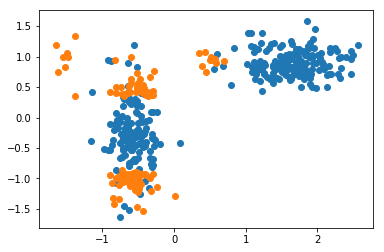

In [ ]:
import matplotlib.pyplot as plt

centers = []
for i in range (1,len(v_list)-1):
    if not v_list[i] == 0 :
        centers .append(x_train_matrix[i])
        
        
        




x_centers = []
y_centers = []
for i in range (len(centers)) :
    x_centers.append(centers[i][0])
    y_centers.append(centers[i][1])
plt.scatter(x_centers,y_centers,alpha=1)

x_miss = []
y_miss = []
for i in range (len(miss_samples)):
    x_miss.append(miss_samples[i][0])
    y_miss.append(miss_samples[i][1])
    
plt.scatter(x_miss , y_miss ,alpha= 1)


x_all_test = []
y_all_test = []
for i in range (len(x_test_matrix)):
    x_all_test.append(x_test_matrix[i][0])
    y_all_test.append(x_test_matrix[i][1])
    
# plt.scatter(x_all_test,y_all_test,alpha=0.05)